In [1]:
import warnings
warnings.filterwarnings('ignore')

# Load NeuroKit and other useful packages
import os
#!pip install neurokit2
import neurokit2 as nk
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]  # Bigger images

# Load lists
from lists import dyads, num_dyads, participants, num_participants

# Preprocess data

In [2]:
# Set sampling rate for neurokit2
sampling_rate = 2000

In [3]:
# Cosine interpolation

def cosine(x, x1, x2):
    from math import pi, cos
    T = x2-x1
    val = 0.5 * cos(2.0 * pi * (x - x1) / T)
    return val

def rpeaks_cosine_interpolation(rpeaks):
    rpeaks_idx = [i for i, x in enumerate(rpeaks) if x == 1]
    rpeaks_cip = [np.nan]*rpeaks_idx[0]

    for i in range(len(rpeaks_idx)):
        if i == len(rpeaks_idx)-1:
            break
        x1 = rpeaks_idx[i]
        x2 = rpeaks_idx[i+1]
        T = x2-x1
        f = lambda x: cosine(x, x1, x2) # (or def f(x): return cosine(x, x1, x2))
        x = np.linspace(x1, x2, T) # span interval with corresponding number of time steps 
        y = [f(x) for x in x]
        rpeaks_cip = rpeaks_cip + y

    rpeaks_cip = rpeaks_cip + [np.nan]*(len(rpeaks)-rpeaks_idx[-1])
    return rpeaks_cip
    # keep in mind: there are nans at the start and end

In [4]:
# Preprocess function
def preprocess(datafile, save_path):
    ecg_raw = [None]*len(participants)
    ecg = [None]*len(participants)
    rpeaks = [None]*len(participants)
    data = [None]*len(participants)

    # Load data: raw ecgs for 300 s at 1000 Hz
    ecg_raw = np.load(datafile)

    for i in range(num_participants):
        ecg_raw[i] = pd.Series(ecg_raw[i].ravel()) # .ravel() to remove redundant parentheses
        # Clean and normalize data
        ecg[i] = nk.ecg_clean(
            ecg_raw[i], 
            sampling_rate=sampling_rate, 
            method="neurokit")
        # Get R-peaks as a binary time series
        rpeaks[i] = nk.ecg_peaks(
            ecg[i], 
            sampling_rate=sampling_rate)
        rpeaks[i] = rpeaks[i][0]["ECG_R_Peaks"]
        # Trigonometric interpolation of r-peaks
        data[i] = rpeaks_cosine_interpolation(rpeaks[i])
        # Trim data to get rid of nans
        data[i] = data[i][2*sampling_rate:300*sampling_rate-2*sampling_rate]
        # Downsampling to 50 Hz
        data[i] = data[i][::40]
        data[i] = np.array(data[i], dtype="float32")
    data = np.array(data)
    np.save(f"{save_path}.npy", data)
    return data, ecg, rpeaks

# Quality check
def quality_check(ecg):
    print("###  ECG quality  ###")
    for i in range(num_participants):
        quality = nk.ecg_quality(
            ecg[i], rpeaks=None, 
            sampling_rate=sampling_rate, 
            method="zhao2018", 
            approach="fuzzy")
        print(f"Person {i} | {quality}")

# Pairwise swapping for permutated dyads
def swap_data(data, save_path):
    def swappairwise(a): 
        # Based on https://stackoverflow.com/a/30132333
        l = len(a) & ~1
        a[1:l:2], a[:l:2] = a[:l:2], a[1:l:2]
    # Create new list
    a = list(range(len(data)))
    a.insert(0, a[-1])
    a.pop()
    swappairwise(a) # i.e. 1,2,3,4,5,6 -> 1,6,3,2,5,3,4
    # Iterate through new list
    data_swap = [None]*len(participants)
    for i in list(range(len(data))):
        data_swap[i] = data[a[i]]
        data_swap[i] = np.array(data_swap[i], dtype="float32")
    data_swap = np.array(data_swap)
    # Save files
    np.save(f"{save_path}.npy", data_swap)
    return data_swap

In [5]:
# SIT
data_sit, ecg_sit, rpeaks_sit = preprocess(
    "data/ecg_raw/ecg_raw_sit.npy", 
    "data/data_sit")
quality_check(ecg_sit)
print("Data shape SIT:", data_sit.shape)

###  ECG quality  ###
Person 0 | Excellent
Person 1 | Barely acceptable
Person 2 | Excellent
Person 3 | Excellent
Person 4 | Excellent
Person 5 | Excellent
Person 6 | Barely acceptable
Person 7 | Excellent
Data shape SIT: (8, 14800)


In [6]:
# GAZE and GAZE-SWAP
data_gaze, ecg_gaze, rpeaks_gaze = preprocess(
    "data/ecg_raw/ecg_raw_gaze.npy", 
    "data/data_gaze")
data_gaze_swap = swap_data(
    data_gaze, 
    "data/data_gaze_swap")
quality_check(ecg_gaze)
print("Data shape GAZE:     ", data_gaze.shape)
print("Data shape GAZE-SWAP:", data_gaze_swap.shape)

###  ECG quality  ###
Person 0 | Excellent
Person 1 | Excellent
Person 2 | Excellent
Person 3 | Excellent
Person 4 | Excellent
Person 5 | Excellent
Person 6 | Excellent
Person 7 | Excellent
Data shape GAZE:      (8, 14800)
Data shape GAZE-SWAP: (8, 14800)


In [7]:
# Sanity check for pariwise swapping
np.equal(
    data_gaze,
    data_gaze_swap)

array([[ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False]])

## Plot data

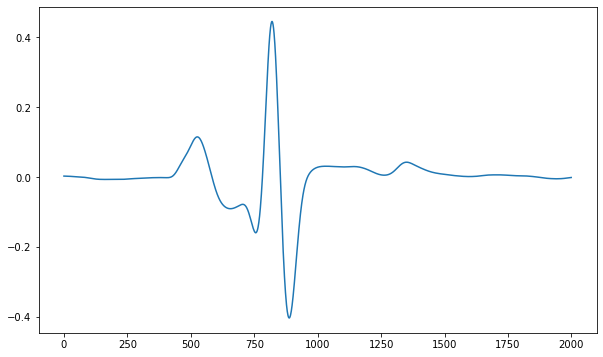

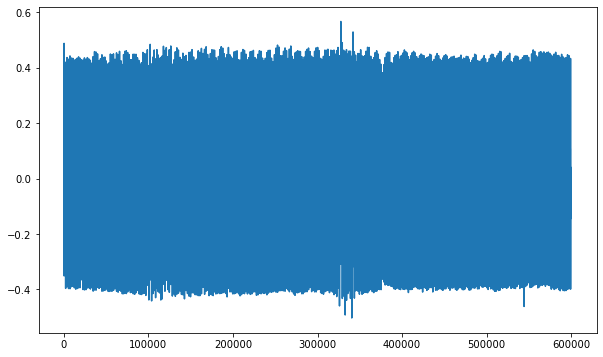

In [8]:
# Show sample data
plt.figure(1)
plt.plot(ecg_sit[0][0:sampling_rate])

plt.figure(2)
plt.plot(ecg_gaze[0])

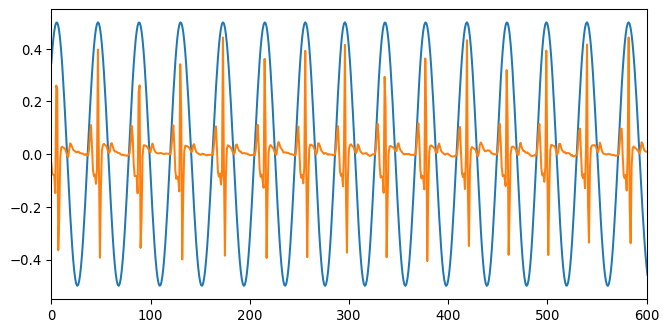

In [9]:
xlim1 = 0*sampling_rate/40
xlim2 = 24*sampling_rate/40

fig = plt.figure(figsize=(8,4), dpi=96)

plt.xlim(xlim1, xlim2/2)

plt.plot(data_sit[0])
plt.plot(ecg_sit[0][2*sampling_rate::40])

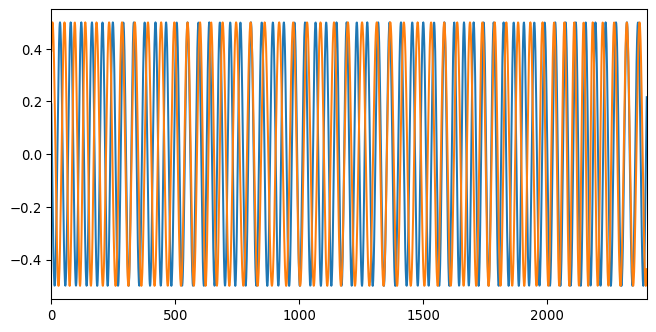

In [10]:
fig = plt.figure(figsize=(8,4), dpi=96)

plt.xlim(xlim1, xlim2*2)
test = np.array(data_gaze[0])

plt.plot(data_gaze[0])
plt.plot(data_gaze[1])

(200.0, 300.0)

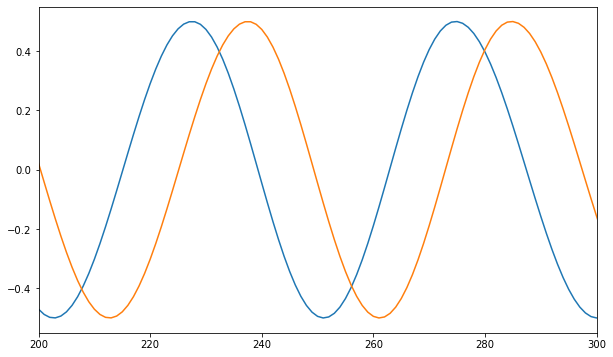

In [11]:
plt.plot(data_sit[1][10:])
plt.plot(data_sit[1][0:])

plt.xlim([200,300])

In [128]:
# Simulate synched data (SYNC)

def rpeaks_cosine_interpolation_with_noise(rpeaks,noise_spread=0):
    rpeaks_idx = [i for i, x in enumerate(rpeaks) if x == 1]
    num_rpeaks = len(rpeaks_idx)
    
    # Add noise
    if noise_spread == 0: 
        noise = [0]*num_rpeaks
    elif noise_spread != 0:
        # Generate normal distribution and round to whole numbers
        noise = np.round(np.random.normal(scale=noise_spread, size=num_rpeaks))
        # Search for sum = 0
        while sum(noise) != 0 or np.round(np.std(noise),1) != noise_spread:
            noise = np.round(np.random.normal(scale=noise_spread, size=num_rpeaks))
        # Convert to ints
        noise = [round(x) for x in noise]

    rpeaks_cip = [np.nan]*(rpeaks_idx[0]+noise[0])
    
    for i in range(num_rpeaks):
        if i == num_rpeaks-1:
            break
        x1 = rpeaks_idx[i]
        x2 = rpeaks_idx[i+1]
        T = x2-x1
        f = lambda x: cosine(x, x1, x2) # (or def f(x): return cosine(x, x1, x2))
        x = np.linspace(x1, x2, T+noise[i+1]) # span interval with corresponding number of time steps 
        y = [f(x) for x in x]
        rpeaks_cip = rpeaks_cip + y

    rpeaks_cip = rpeaks_cip + [np.nan]*(len(rpeaks)-rpeaks_idx[-1])
    return rpeaks_cip
    # keep in mind: there are nans at the start and end

In [13]:
    # Trigonometric interpolation of r-peaks
    data[i] = rpeaks_cosine_interpolation(rpeaks[i])
    # Trim data to get rid of nans
    data[i] = data[i][2*sampling_rate:300*sampling_rate-2*sampling_rate]
    # Downsampling to 50 Hz
    data[i] = data[i][::40]
    data[i] = np.array(data[i], dtype="float32")
    data = np.array(data)
    np.save(f"{save_path}.npy", data)
    return data, ecg, rpeaks

NameError: name 'rpeaks' is not defined

array([[1.      , 0.548844],
       [0.548844, 1.      ]])

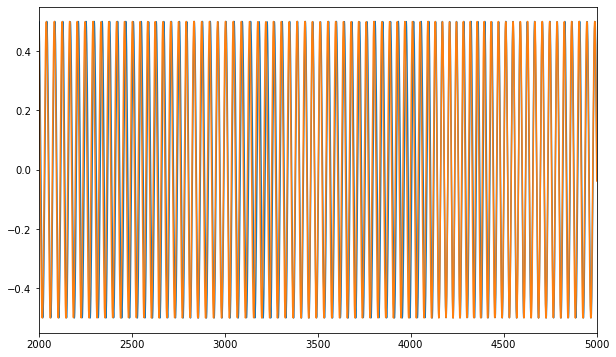

In [170]:
a = rpeaks_cosine_interpolation_with_noise(rpeaks_sit[0], noise_spread=50)
a = a[::40]
plt.plot(a[100:])
plt.plot(data_sit[0])
plt.xlim([2000,5000])
np.corrcoef((a[100:-100]),(data_sit[0]))

In [173]:
rpeaks_idx = [i for i, x in enumerate(rpeaks_sit[1]) if x == 1]
rpeaks_idx


[871,
 2767,
 4946,
 7194,
 9383,
 11518,
 13501,
 15389,
 17421,
 19514,
 21707,
 23806,
 25961,
 27884,
 29653,
 31357,
 33200,
 35645,
 38092,
 40409,
 42591,
 44558,
 46311,
 47992,
 49807,
 51684,
 53651,
 55653,
 57693,
 59717,
 61764,
 63828,
 65844,
 67716,
 69394,
 71053,
 72891,
 74971,
 77210,
 79400,
 81635,
 83796,
 85916,
 88006,
 90086,
 92018,
 93766,
 95517,
 97560,
 100383,
 102923,
 105305,
 107580,
 109831,
 112043,
 114208,
 116399,
 118543,
 120739,
 122853,
 125041,
 127190,
 129436,
 131574,
 133588,
 135385,
 137361,
 139551,
 141982,
 144211,
 146041,
 148112,
 150183,
 152006,
 153643,
 155265,
 156967,
 158930,
 161322,
 163799,
 166192,
 168513,
 170671,
 172522,
 174253,
 175934,
 177718,
 179879,
 182162,
 184518,
 186809,
 189007,
 191122,
 193006,
 194674,
 196262,
 197842,
 199707,
 201904,
 204234,
 206501,
 208775,
 210943,
 213001,
 214720,
 216294,
 217814,
 219402,
 221460,
 224010,
 226489,
 228743,
 231002,
 233163,
 235160,
 236941,
 238596,
 2

In [176]:
noise = np.round(np.random.normal(scale=50, size=300))
# Search for sum = 0
while sum(noise) != 0 or np.round(np.std(noise),1) != 50:
    noise = np.round(np.random.normal(scale=50, size=300))
np.mean(abs(noise))/1800

0.021874074074074074

In [136]:
for i in range(0,200,10):
    a = rpeaks_cosine_interpolation_with_noise(rpeaks_sit[0], noise_spread=i)
    a = a[::40]
    print(i, np.corrcoef((a[100:-100]),(data_sit[0]))[0,1])

0 0.9999999999999997
10 0.9704417994804025
20 0.8798621310775269
30 0.9376327529887387
40 0.4974664814241775
50 0.6420515852789336
60 0.21751059122755972
70 0.1737495789102815
80 0.1862508171719471
90 -0.046838531737534765
100 0.43442834450813345


KeyboardInterrupt: 

(4400.0, 7000.0)

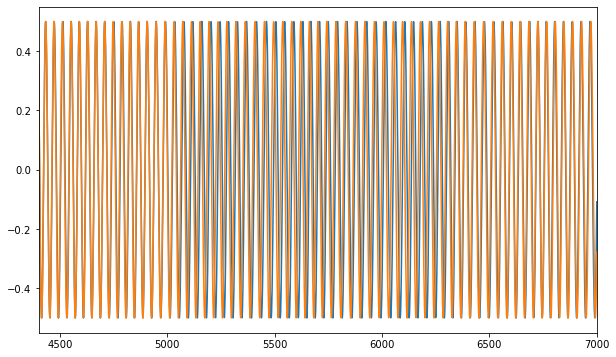